In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
import joblib

In [2]:
data = pd.read_csv("C:\\Users\\LENOVO\\Downloads\\Online_Payments_Fraud_Detection.csv")
print(data.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [3]:
# Informations sur dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None


In [4]:
# Distribution des classes
print(data['isFraud'].value_counts())

isFraud
0    6354407
1       8213
Name: count, dtype: int64


In [5]:
# Distribution des montants des transactions
plt.figure(figsize=(10, 5))
sns.histplot(data[data['isFraud'] == 1]['amount'], color='red', label='Frauduleuses', kde=True)
sns.histplot(data[data['isFraud'] == 0]['amount'], color='blue', label='Non frauduleuses', kde=True)
plt.title('Distribution des montants des transactions')
plt.xlabel('Montant des transactions')
plt.ylabel('Densité')
plt.legend()
# Enregistrement de la figure
plt.savefig('distribution_transactions.png')
plt.close()

In [6]:
#Split Train/Test
X = data.drop(['isFraud', 'type', 'nameOrig', 'nameDest', 'step'], axis=1)
y = data['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [7]:
# Appliquer SMOTE Synthetic Minority Oversampling TEchnique  
smote = SMOTE(sampling_strategy=0.1, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [8]:
# Vérification des valeurs manquantes
print(X_train_resampled.isnull().sum())

amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFlaggedFraud    0
dtype: int64


In [9]:
# Afficher les informations générales
print(X_train_resampled.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4892893 entries, 0 to 4892892
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   amount          float64
 1   oldbalanceOrg   float64
 2   newbalanceOrig  float64
 3   oldbalanceDest  float64
 4   newbalanceDest  float64
 5   isFlaggedFraud  int64  
dtypes: float64(5), int64(1)
memory usage: 224.0 MB
None


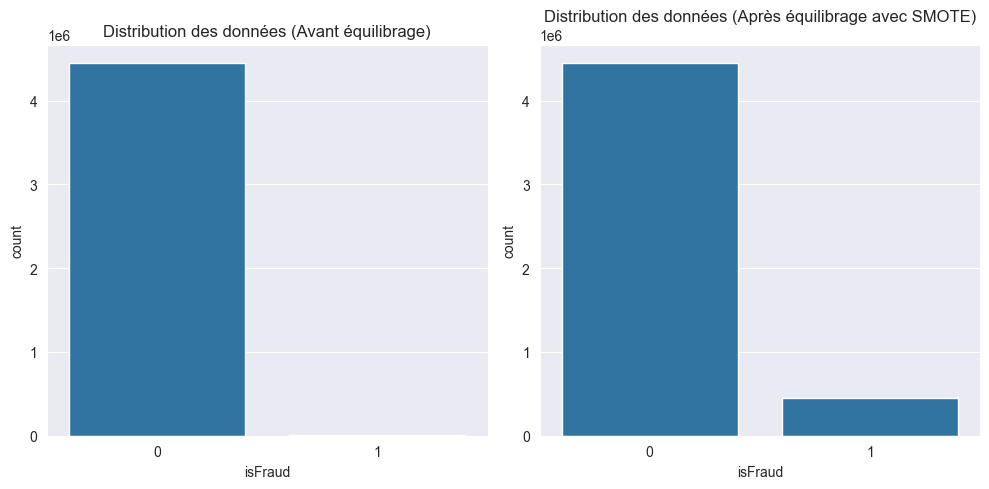

In [10]:
y_train_df = y_train.to_frame()
y_train_resampled_df = y_train_resampled.to_frame()

# Distribution des données avant SMOTE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='isFraud', data=y_train_df)
plt.title('Distribution des données (Avant équilibrage)')

# Distribution des données après SMOTE
plt.subplot(1, 2, 2)
sns.countplot(x='isFraud', data=y_train_resampled_df)
plt.title('Distribution des données (Après équilibrage avec SMOTE)')

plt.tight_layout()

# Sauvegarder la figure
plt.savefig('distribution_avant_apres_smote.png')

# Afficher la figure
plt.show()

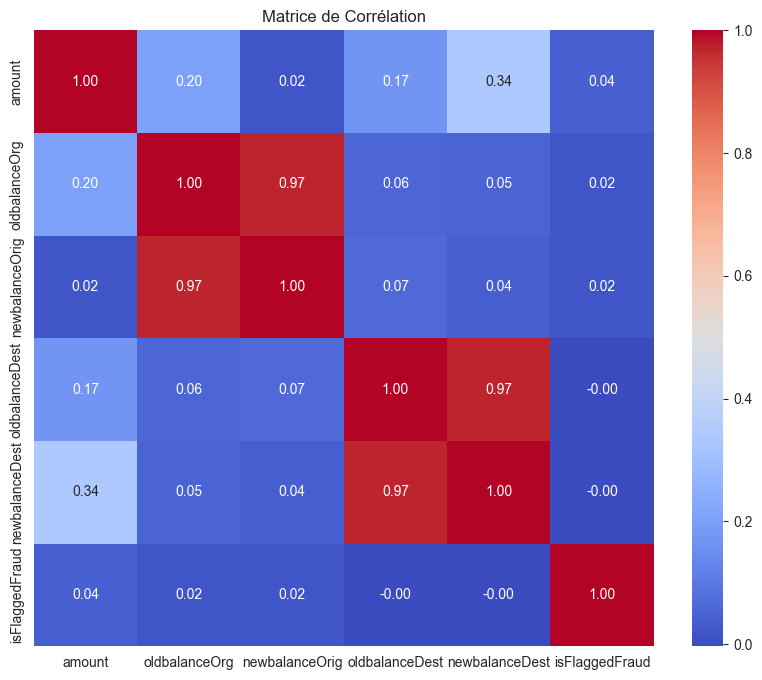

In [11]:
# Matrice de corrélation 
all_features = pd.concat([X_train_resampled, X_test])
# Sélectionner les caractéristiques numériques
numeric_features = all_features.select_dtypes(include=['float64', 'int64'])
# Calculer la matrice de corrélation
correlation_matrix = numeric_features.corr()
# Afficher la matrice de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de Corrélation')
plt.savefig('matrice_correlation.png')  
plt.show()

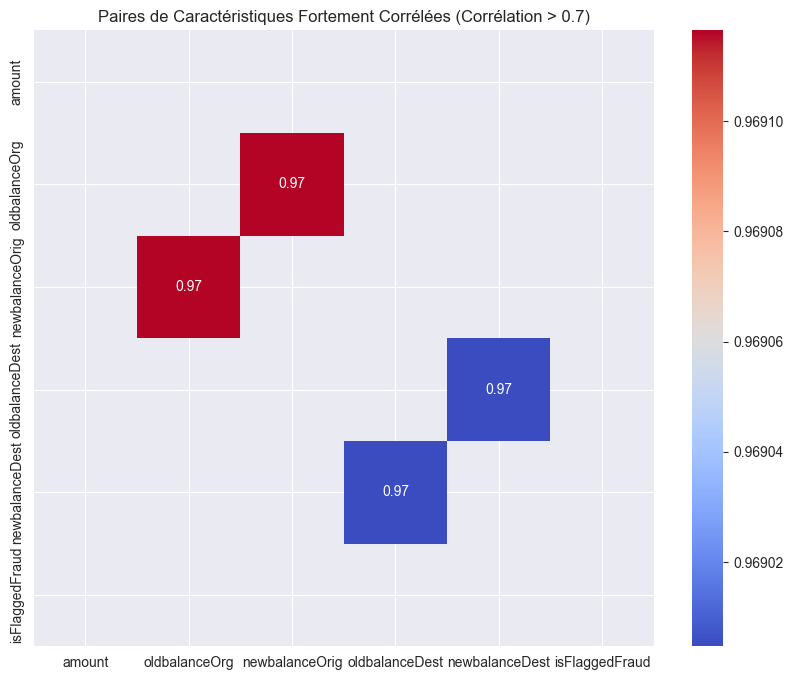

In [12]:
all_features = pd.concat([X_train_resampled, X_test])
numeric_features = all_features.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_features.corr()
threshold = 0.7
strongly_correlated = (correlation_matrix.abs() > threshold) & (correlation_matrix != 1)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix[strongly_correlated], annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Paires de Caractéristiques Fortement Corrélées (Corrélation > {})'.format(threshold))
plt.savefig('strongly_correlated_features_heatmap.png') 
plt.show()

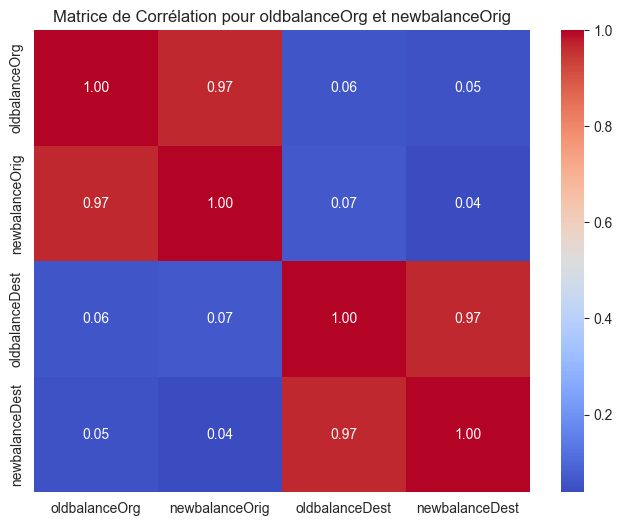

In [13]:
#Feature Selection
selected_features = pd.concat([X_train_resampled, X_test])[['oldbalanceOrg', 'newbalanceOrig','oldbalanceDest','newbalanceDest']]

# Calculer la matrice de corrélation pour ces caractéristiques
correlation_matrix_selected = selected_features.corr()

# Afficher la matrice de corrélation
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_selected, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de Corrélation pour oldbalanceOrg et newbalanceOrig')
plt.savefig('correlation_matrix_selected_features.png') 
plt.show()

In [14]:
log_reg_unbalanced_no_fs = LogisticRegression(solver='liblinear', max_iter=1000)

# Entraîner le modèle sur les données d'entraînement non équilibrées
log_reg_unbalanced_no_fs.fit(X_train, y_train)

# Faire des prédictions sur les données de test
predictions_unbalanced_no_fs = log_reg_unbalanced_no_fs.predict(X_test)

# Évaluer les performances du modèle
print("Sur les données non équilibrées sans sélection de caractéristiques :")
print(classification_report(y_test, predictions_unbalanced_no_fs))

Sur les données non équilibrées sans sélection de caractéristiques :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.35      0.78      0.48      2464

    accuracy                           1.00   1908786
   macro avg       0.67      0.89      0.74   1908786
weighted avg       1.00      1.00      1.00   1908786


In [15]:
log_reg_balanced_no_fs = LogisticRegression(solver='liblinear', max_iter=1000)

# Entraîner le modèle sur les données d'entraînement équilibrées
log_reg_balanced_no_fs.fit(X_train_resampled, y_train_resampled)

# Faire des prédictions sur les données de test
predictions_balanced_no_fs = log_reg_balanced_no_fs.predict(X_test)


In [16]:
log_reg_unbalanced_fs = LogisticRegression()

# Entraîner le modèle sur les données d'entraînement non équilibrées avec sélection de caractéristiques
log_reg_unbalanced_fs.fit(X_train[selected_features.columns], y_train)

# Faire des prédictions sur les données de test
predictions_unbalanced_fs = log_reg_unbalanced_fs.predict(X_test[selected_features.columns])


In [17]:
# Créer un modèle de régression logistique avec sélection de caractéristiques sur les données équilibrées
log_reg_balanced_fs = LogisticRegression()

# Entraîner le modèle sur les données d'entraînement équilibrées avec sélection de caractéristiques
log_reg_balanced_fs.fit(X_train_resampled[selected_features.columns], y_train_resampled)

# Faire des prédictions sur les données de test
predictions_balanced_fs = log_reg_balanced_fs.predict(X_test[selected_features.columns])


In [19]:
# Random Forest on Unbalanced Data Without FS
rf_unbalanced_no_fs = RandomForestClassifier(random_state=42)
rf_unbalanced_no_fs.fit(X_train, y_train)
predictions_rf_unbalanced_no_fs = rf_unbalanced_no_fs.predict(X_test)
# Random Forest on Unbalanced Data With FS
rf_unbalanced_fs = RandomForestClassifier(random_state=42)
rf_unbalanced_fs.fit(X_train[selected_features.columns], y_train)
predictions_rf_unbalanced_fs = rf_unbalanced_fs.predict(X_test[selected_features.columns])

# Random Forest on Balanced Data Without FS
rf_balanced_no_fs = RandomForestClassifier(random_state=42)
rf_balanced_no_fs.fit(X_train_resampled, y_train_resampled)
predictions_rf_balanced_no_fs = rf_balanced_no_fs.predict(X_test)

# Random Forest on Balanced Data With FS
rf_balanced_fs = RandomForestClassifier(random_state=42)
rf_balanced_fs.fit(X_train_resampled[selected_features.columns], y_train_resampled)
predictions_rf_balanced_fs = rf_balanced_fs.predict(X_test[selected_features.columns])


In [23]:
# Select the features for training and prediction
selected_features = ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
all_features = X.columns

# Define a function to calculate and display metrics
def display_metrics(y_true, y_pred, y_pred_proba):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("\n")

print("Random Forest on Unbalanced Data Without FS:")
display_metrics(y_test, predictions_rf_unbalanced_no_fs, rf_unbalanced_no_fs.predict_proba(X_test[all_features])[:, 1])

print("Random Forest on Unbalanced Data With FS:")
display_metrics(y_test, predictions_rf_unbalanced_fs, rf_unbalanced_fs.predict_proba(X_test[selected_features])[:, 1])

print("Random Forest on Balanced Data Without FS:")
display_metrics(y_test, predictions_rf_balanced_no_fs, rf_balanced_no_fs.predict_proba(X_test[all_features])[:, 1])

print("Random Forest on Balanced Data With FS:")
display_metrics(y_test, predictions_rf_balanced_fs, rf_balanced_fs.predict_proba(X_test[selected_features])[:, 1])


Random Forest on Unbalanced Data Without FS:


IndexError: list index out of range

In [ ]:
#RandomForest sur les data Unbalanced With fs
rf = RandomForestClassifier()
param_dist = {
    'n_estimators':[50,100],
    'max_depth': [6, 8, 10],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 5],
    'criterion': ['gini']
}

# Créer le RandomizedSearchCV avec sélection de caractéristiques
random_search_fs = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=20, cv=3, scoring='accuracy', random_state=42, n_jobs=-1)
random_search_fs.fit(X_train[selected_features.columns], y_train)

# Faire des prédictions sur les données de test
predictions_fs = random_search_fs.predict(X_test[selected_features.columns])

In [ ]:
##RandomForest sur les data Unbalanced Without fs
random_search_no_fs = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=20, cv=3, scoring='accuracy', random_state=42,n_jobs=-1)
random_search_no_fs.fit(X_train, y_train)

# Faire des prédictions sur les données de test
predictions_no_fs = random_search_no_fs.predict(X_test)

In [ ]:
#RandomForest sur les data balanced Without fs
random_search_no_fs_balanced = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=20, cv=3, scoring='accuracy',verbose=4, random_state=42,n_jobs=-1)
random_search_no_fs_balanced.fit(X_train_resampled, y_train_resampled)
# Faire des prédictions sur les données de test
predictions_Random_no_fs = random_search_no_fs.predict(X_test)

In [ ]:
#RandomForest sur les data balanced With fs
random_search_fs_balanced = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=20, cv=3, scoring='accuracy',verbose=4, random_state=42,n_jobs=-1)
random_search_fs_balanced.fit(X_train_resampled[selected_features.columns], y_train_resampled)

# Faire des prédictions sur les données de test
predictions_Random_fs = random_search_no_fs.predict(X_test[selected_features.columns])

In [ ]:
# Logistic Regression Models
joblib.dump(log_reg_balanced_no_fs, 'logistic_regression_balanced_no_fs_model.pkl')
joblib.dump(log_reg_balanced_fs, 'logistic_regression_balanced_fs_model.pkl')

# RandomForest Models
joblib.dump(rf_balanced_no_fs, 'random_forest_balanced_no_fs_model.pkl')
joblib.dump(rf_balanced_fs, 'random_forest_balanced_fs_model.pkl')
# RandomForest Models
joblib.dump(random_search_no_fs, 'random_forest_Hyper_balanced_no_fs_model.pkl')
joblib.dump(random_search_fs_balanced, 'random_forest_Hyper_balanced_fs_model.pkl')

In [ ]:
# Create a DataFrame to store metrics
metrics_df = pd.DataFrame(columns=['Model', 'Data', 'Feature Selection', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])

# Define a function to calculate and append metrics
def append_metrics(model_name, data_type, fs_type, y_true, y_pred_proba):
    y_pred = (y_pred_proba[:,1] > 0.5).astype(int)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba[:,1])
    metrics_df.loc[len(metrics_df)] = [model_name, data_type, fs_type, accuracy, precision, recall, f1, roc_auc]

# Append metrics for each model
append_metrics('Logistic Regression', 'Unbalanced', 'No FS', y_test, log_reg_unbalanced_no_fs.predict_proba(X_test))
append_metrics('Logistic Regression', 'Balanced', 'No FS', y_test, log_reg_balanced_no_fs.predict_proba(X_test))
append_metrics('Logistic Regression', 'Unbalanced', 'With FS', y_test, log_reg_unbalanced_fs.predict_proba(X_test[selected_features.columns]))
append_metrics('Logistic Regression', 'Balanced', 'With FS', y_test, log_reg_balanced_fs.predict_proba(X_test[selected_features.columns]))
append_metrics('RandomForest', 'Unbalanced', 'No FS', y_test, rf_unbalanced_no_fs.predict_proba(X_test))
append_metrics('RandomForest', 'Balanced', 'No FS', y_test, rf_balanced_no_fs.predict_proba(X_test))
append_metrics('RandomForest', 'Unbalanced', 'With FS', y_test, rf_unbalanced_no_fs.predict_proba(X_test[selected_features.columns]))
append_metrics('RandomForest', 'Balanced', 'With FS', y_test, rf_balanced_fs.predict_proba(X_test[selected_features.columns]))

# Save metrics DataFrame
metrics_df.to_csv('Tablemetrics.csv', index=False)


In [ ]:
plt.figure(figsize=(10, 8))

# Add ROC curves for Logistic Regression
fpr, tpr, _ = roc_curve(y_test, log_reg_unbalanced_no_fs.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='Logistic Regression Unbalanced Without FS')

fpr, tpr, _ = roc_curve(y_test, log_reg_balanced_no_fs.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='Logistic Regression Balanced Without FS')

fpr, tpr, _ = roc_curve(y_test, log_reg_unbalanced_fs.predict_proba(X_test[selected_features.columns])[:, 1])
plt.plot(fpr, tpr, label='Logistic Regression Unbalanced With FS')

fpr, tpr, _ = roc_curve(y_test, log_reg_balanced_fs.predict_proba(X_test[selected_features.columns])[:, 1])
plt.plot(fpr, tpr, label='Logistic Regression Balanced With FS')

# Add ROC curves for RandomForest
fpr, tpr, _ = roc_curve(y_test, rf_unbalanced_no_fs.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='Random Forest Unbalanced Without FS')

fpr, tpr, _ = roc_curve(y_test, rf_balanced_no_fs.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='Random Forest Balanced Without FS')

fpr, tpr, _ = roc_curve(y_test, rf_balanced_fs.predict_proba(X_test[selected_features.columns])[:, 1])
plt.plot(fpr, tpr, label='Random Forest Balanced With FS')

plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.savefig('roc_curves.png')
plt.show()